# Super resolution with implicit neural representations 

In [85]:
%matplotlib inline
from nn_mri import ImageFitting_set, Siren, get_mgrid, cases
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray, gray2rgb

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean

import torch


steps_til_summary = 50
scale = 1
total_steps = 3000

radius =5
color = (255, 0, 0)
thickness = 1

In [86]:
def calculate_contrast(case, image, focus):
    """ calculates the contrast between the cancer and the collateral benign tissue"""
    # cancer center x,y locations
    cc_x, cc_y = tuple((i -focus) for i in case.cancer_loc)
    # collateral benign x,y locations
    cb_x, cb_y = tuple((i -focus) for i in case.collateral_loc)
    cancer_area = image[cc_x - 1 : cc_x + 1, cc_y - 1 : cc_y + 1]
    collateral_area = image[cb_x - 1 : cb_x + 1, cb_y - 1 : cb_y + 1]
    
    #cancer_mean
    cm = cancer_area.mean()
    #begign_mean
    bm = collateral_area.mean()
    #cancer_variance
    varc = np.std(cancer_area)**2
    #benign variance
    varb = np.std(collateral_area)**2
    
    C = (cancer_area.mean() - collateral_area.mean())/cancer_area.mean()
    CNR = (cancer_area.mean() - collateral_area.mean())/np.sqrt(varc + varb)
    return C, CNR

In [ ]:
#TODO automation for the non-directional approach as well
#TODO one run for quantitative results, another run for image generation
total_steps = 4000
orig_CC_ratio_list = []
SR_CC_ratio_list = []
NLM_CC_ratio_list = []
gland_start = 40
focus_size = 50
show_cancer = False
weighted = False
display = False
do_detection = False
sigma_est = 2
patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=3)
metrics = {'C', 'CNR'}
filename = 'exp_0.csv'
with open(filename, 'w') as f:
    f.write('seed,patient,direction,epoch,image,metric,performance\n')

for seed in range(10):
    torch.manual_seed(seed)
    orig_CC_ratio = []
    SR_CC_ratio = []
    NLM_CC_ratio = []
    for case in cases:
        _slice = case.cancer_slice
        if show_cancer : #TODO add titles and pt_id descriptions
            orig = case.dwi[:, :, _slice, :].mean(-1)
            center_coordinates = case.cancer_loc[::-1]
            height, width = orig.shape
            img = orig
            img = gray2rgb(img*255/img.max())
            img = np.ascontiguousarray(img, dtype=np.uint8)

            cv2.circle(img, center_coordinates, radius, color, thickness)
            plt.figure()
            plt.imshow(img, cmap='gray')
            
        predicted_XYZ = []
        original_XYZ = []
        directions = ['x', 'y', 'z']
        for direction in range(3):  # gradient directions x, y, z
            ends = np.cumsum(case.acquisitions)
            starts = ends - case.acquisitions
            
            # Create a dataset for training SIREN
            img_dataset = []
            for acq in range(starts[direction], ends[direction]):
                img = case.dwi[gland_start : gland_start + focus_size,
                               gland_start : gland_start + focus_size,
                               _slice,
                               acq]
                img_dataset.append(Image.fromarray(img))

            dataset = ImageFitting_set(img_dataset)
            orig = dataset.mean
            pt_no = case.pt_id.split('-')[-1]

                
            original_XYZ.append(orig)
            dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
            img_siren = Siren(in_features=2, out_features=1, hidden_features=128, 
                         hidden_layers=2, outermost_linear=True)
            img_siren.cuda()
            torch.cuda.empty_cache()
            optim = torch.optim.Adam(lr=0.0003, params=img_siren.parameters())
            ctr = 0
            print(f'Training for direction {directions[direction]}')
            for step in range(total_steps):
                size = dataset.shape
                for sample in range(len(dataset)):                    
                    ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
                    ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
                    model_output, coords = img_siren(model_input)
                    if weighted:
                        weights = ground_truth/ground_truth.sum()
                        weights -= weights.min()
                        weights += 0.000001
                    else:
                        weights = 1
                    loss = weights*(model_output - ground_truth)**2
                    loss = loss.mean()
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                if not step % steps_til_summary:
                    coords2 = get_mgrid(size[0]*scale, 2).cuda()
                    superres, _ = img_siren(coords2)
                    pr = superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy()
                    if ctr < 50:
                        predicted = superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy()
                        out_img = predicted
                    else:
                        predicted += superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy()
                        out_img = predicted/(ctr+1)
                    ctr += 1
                    nlm = denoise_nl_means(out_img, h=1.15 * sigma_est, fast_mode=True, **patch_kw)
                    orig2 = rescale(orig, scale, anti_aliasing=False)
                    images = {'mean':orig, 'super':pr, 'ensemble':out_img, 'NLM':nlm}

                    with open(filename, 'a') as f:
                        for image in images.keys():
                            for inx, metric in enumerate(metrics):
                                f.write('{},{},{},{},{},{},{}\n'.format(seed, pt_no, directions[direction], step,
                                                                        image, metric,
                                                                        calculate_contrast(case, 
                                                                                           images[image],
                                                                                           gland_start)[inx]))

            predicted_XYZ.append(out_img)
            
            if display:
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15),
                                   sharex=True, sharey=True)

                ax[0].imshow(rescale(orig, scale, anti_aliasing=False), cmap='gray')
                ax[0].axis('off')
                ax[0].set_title('mean image')

                ax[1].imshow(out_img, cmap='gray')
                ax[1].axis('off')
                ax[1].set_title('superres')

        predicted = sum(predicted_XYZ)/len(predicted_XYZ)
        orig = sum(original_XYZ)/len(original_XYZ)    
        noisy = predicted
        
        if display:
            denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
                                       **patch_kw)

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15),
                                   sharex=True, sharey=True)


            ax[0].imshow(rescale(orig, scale, anti_aliasing=False), cmap='gray')
            ax[0].axis('off')
            ax[0].set_title('original')
            ax[1].imshow(noisy, cmap='gray')
            ax[1].axis('off')
            ax[1].set_title('superres')
            ax[2].imshow(denoise, cmap='gray')
            ax[2].axis('off')
            ax[2].set_title('superres + NLM')

            fig.tight_layout()
            plt.show()
        
        if do_detection:
            a = rescale(orig, 1, anti_aliasing=True)
            denoise_fast = denoise_nl_means(a, h=0.8 * sigma_est, fast_mode=True,
                                            **patch_kw)
            (thresh, blackAndWhiteImage) = cv2.threshold(a, a.max()*0.95, 255, cv2.THRESH_BINARY)
            (thresh, blackAndWhiteImage2) = cv2.threshold(noisy, noisy.max()*0.95, 255, cv2.THRESH_BINARY)
            (thresh, blackAndWhiteImage3) = cv2.threshold(denoise, denoise.max()*0.95, 255, cv2.THRESH_BINARY)

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15),
                                   sharex=True, sharey=True)


            ax[0].imshow(rescale(a, scale, anti_aliasing=False), cmap='gray')
            ax[0].imshow(rescale(blackAndWhiteImage, scale, anti_aliasing=True), 'hot',alpha=0.5)
            ax[0].axis('off')
            ax[0].axis('off')
            ax[0].set_title('original')

            ax[1].imshow(noisy, cmap='gray')
            ax[1].imshow(blackAndWhiteImage2,'hot', alpha=0.5)
            ax[1].axis('off')
            ax[1].axis('off')
            ax[1].set_title('superres')
            ax[2].imshow( denoise, cmap='gray')
            ax[2].imshow(blackAndWhiteImage3, 'hot', alpha=0.5)
            ax[2].axis('off')
            ax[2].set_title('superres + NLM')



Training for direction x
Training for direction y
Training for direction z
Training for direction x
Training for direction y
Training for direction z
Training for direction x
Training for direction y
Training for direction z
Training for direction x
Training for direction y
Training for direction z


100%|██████████| 1000/1000 [00:21<00:00, 45.59it/s]


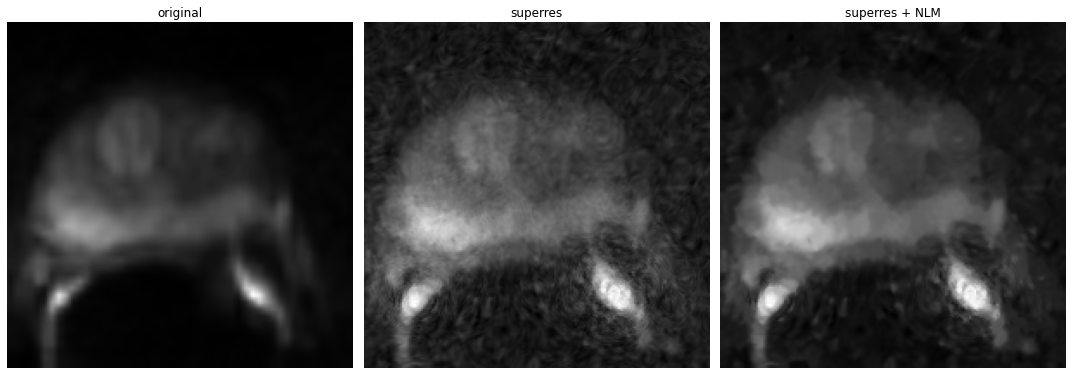

100%|██████████| 1000/1000 [00:43<00:00, 22.91it/s]


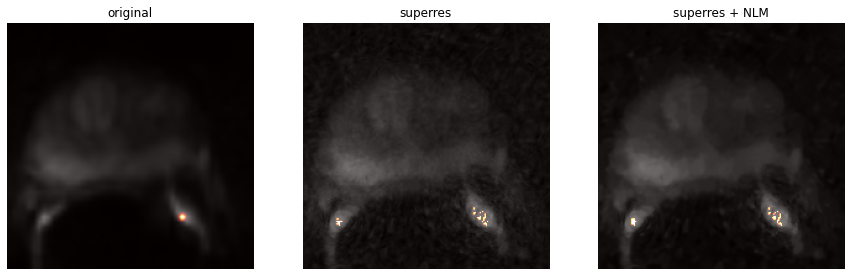

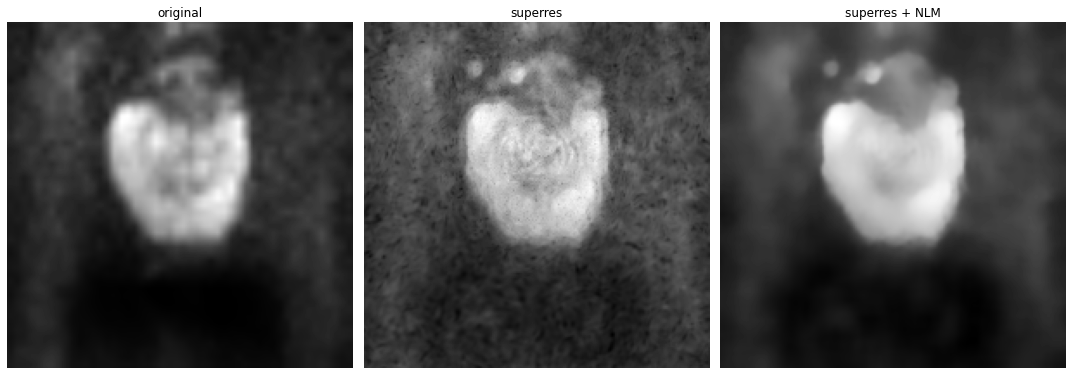

100%|██████████| 1000/1000 [00:42<00:00, 23.75it/s]


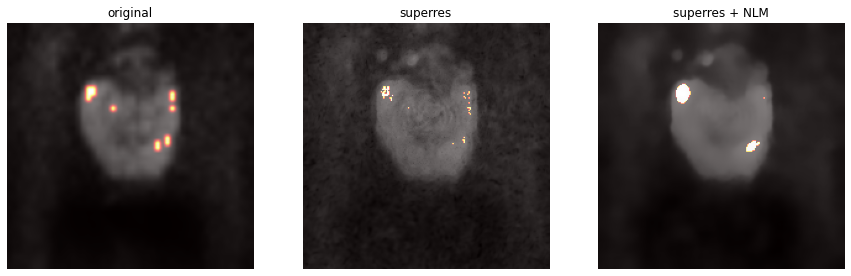

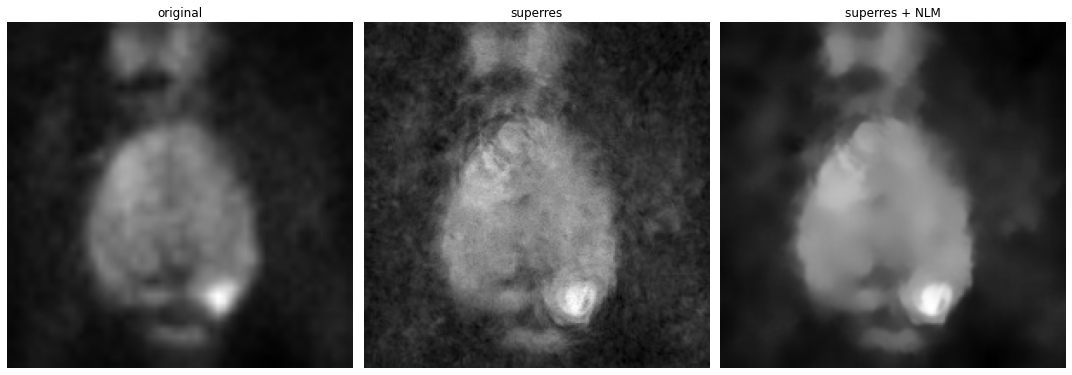

100%|██████████| 1000/1000 [00:44<00:00, 22.49it/s]


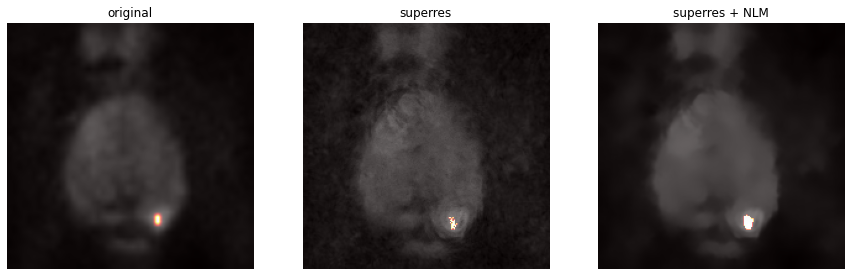

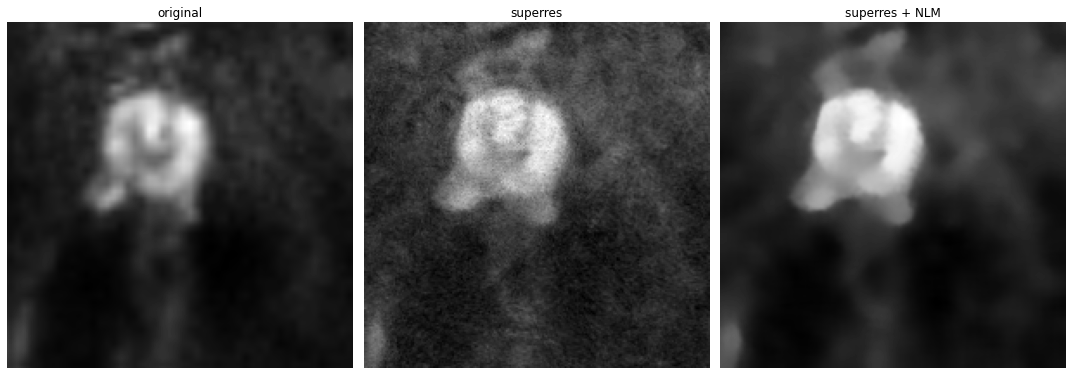

100%|██████████| 1000/1000 [00:22<00:00, 44.81it/s]


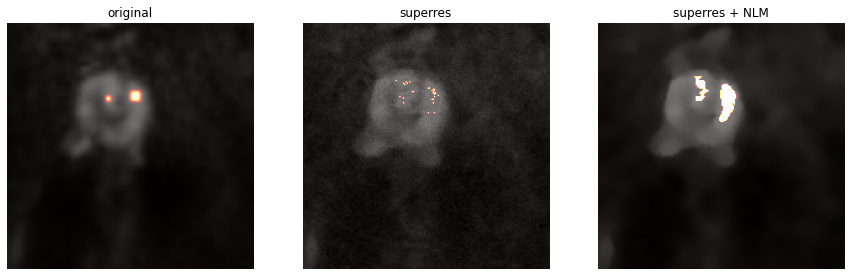

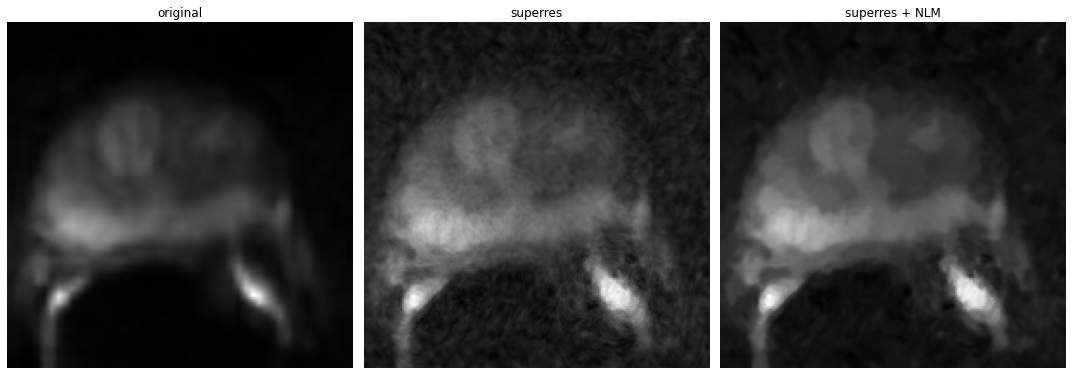

100%|██████████| 1000/1000 [00:44<00:00, 22.51it/s]


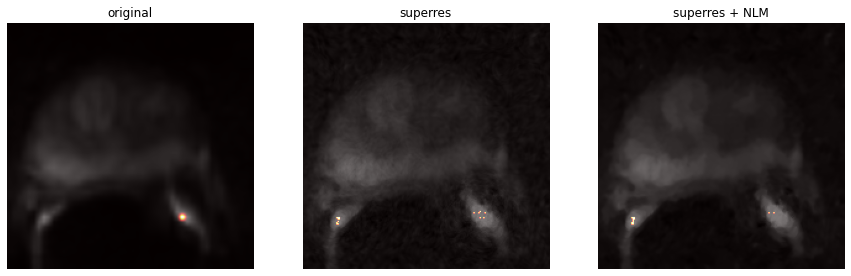

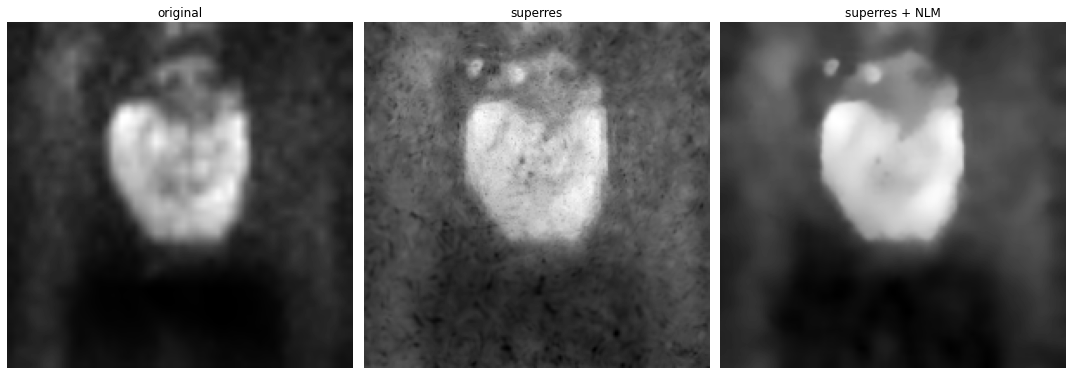

100%|██████████| 1000/1000 [00:42<00:00, 23.63it/s]


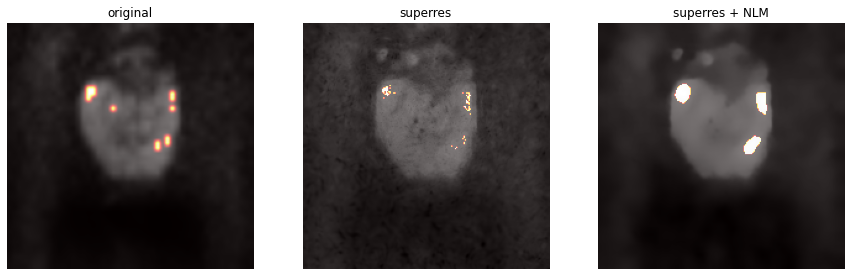

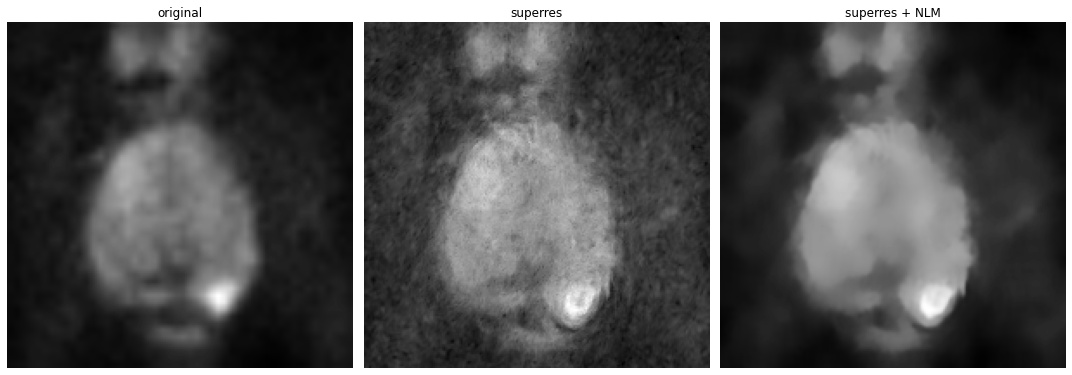

100%|██████████| 1000/1000 [00:44<00:00, 22.64it/s]


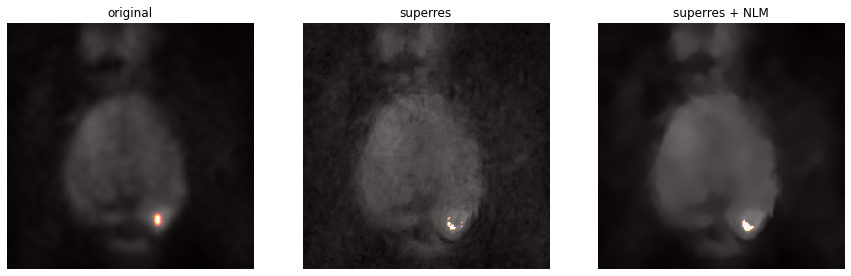

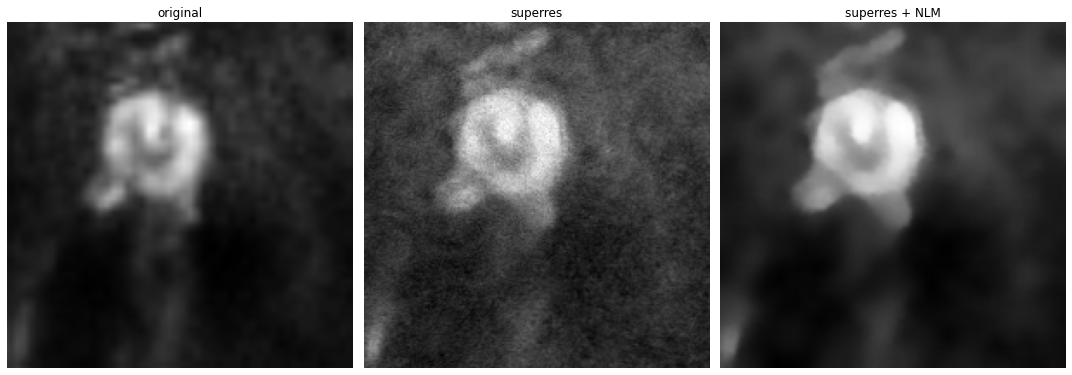

100%|██████████| 1000/1000 [00:21<00:00, 45.99it/s]


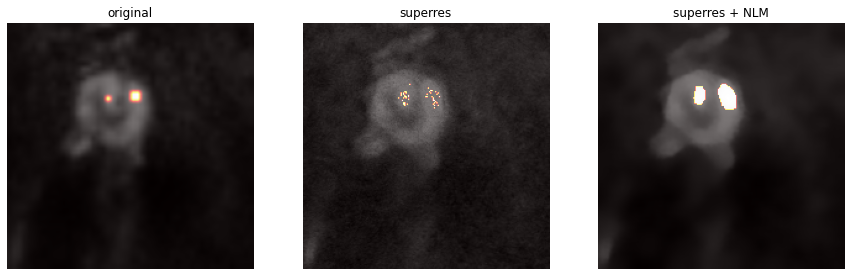

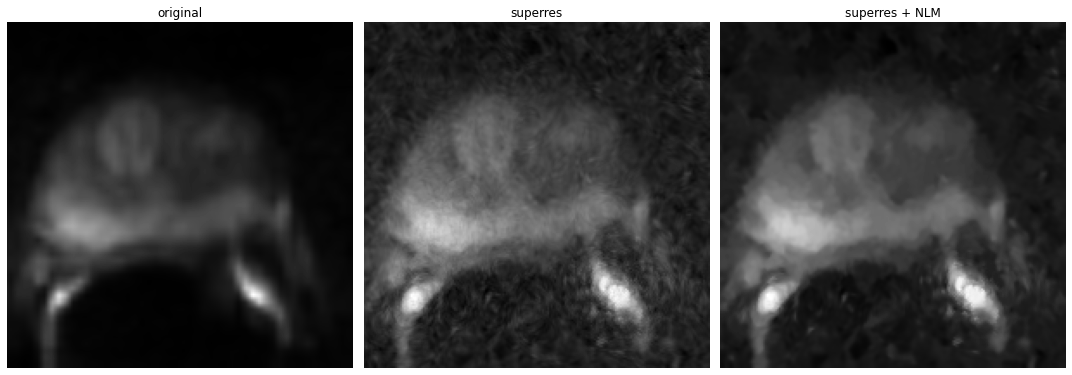

100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]


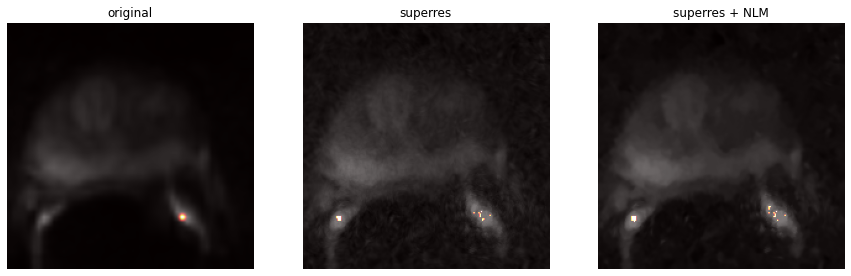

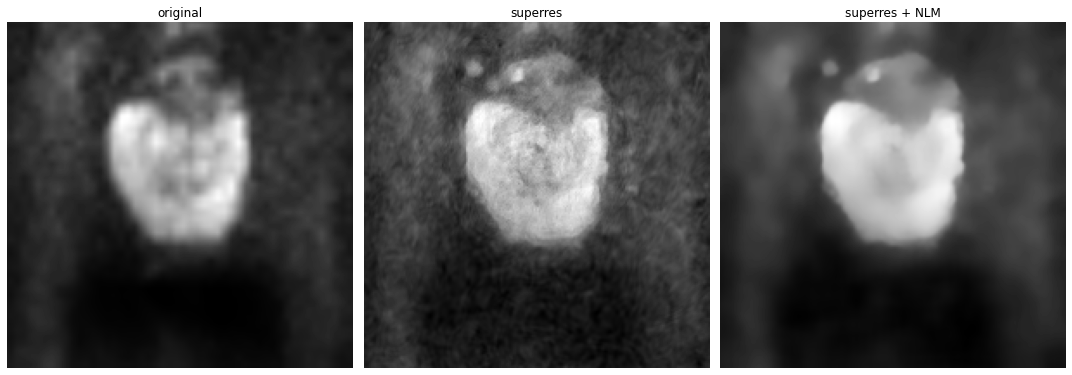

100%|██████████| 1000/1000 [00:41<00:00, 23.94it/s]


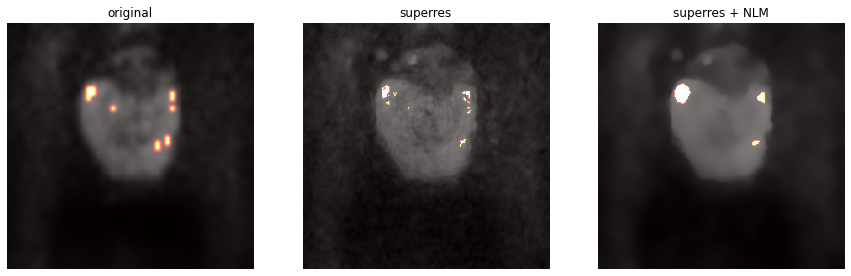

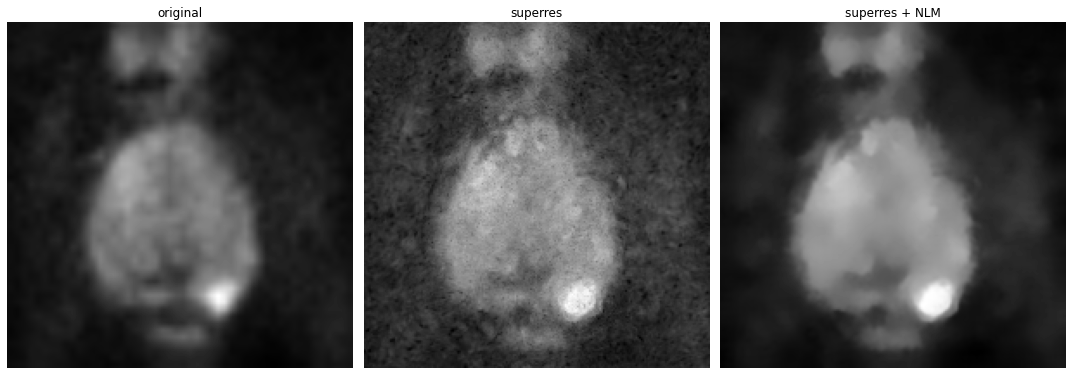

100%|██████████| 1000/1000 [00:44<00:00, 22.67it/s]


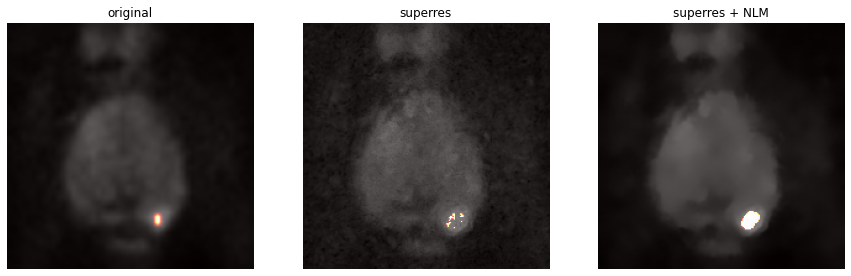

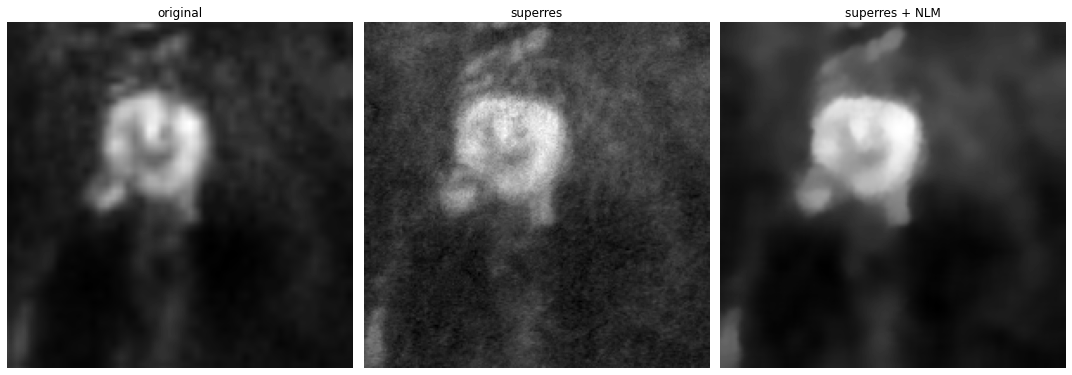

100%|██████████| 1000/1000 [00:22<00:00, 45.18it/s]


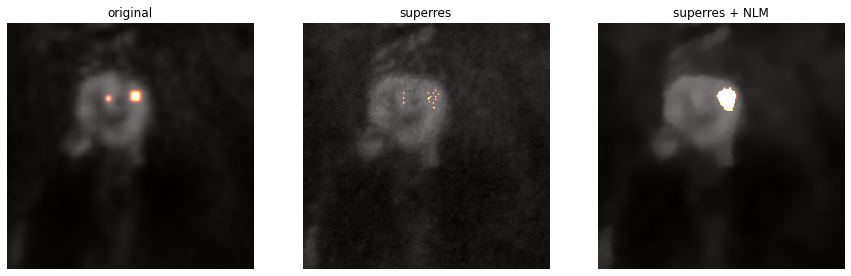

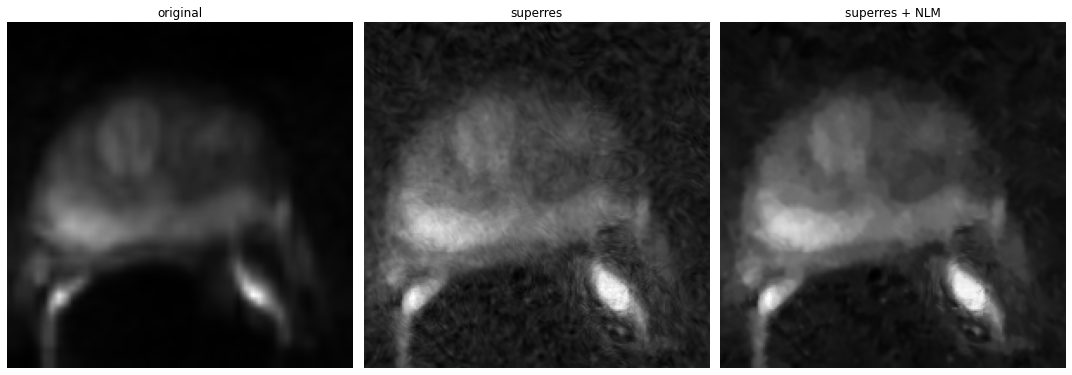

100%|██████████| 1000/1000 [00:43<00:00, 23.00it/s]


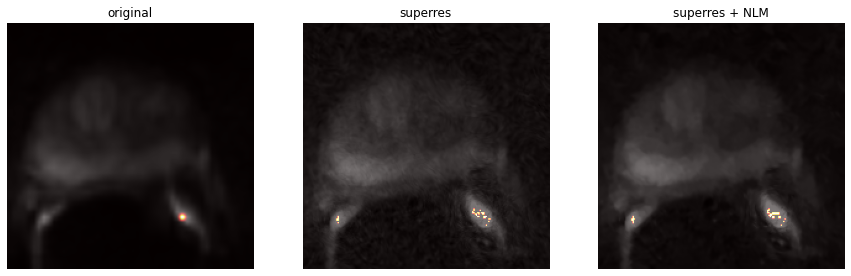

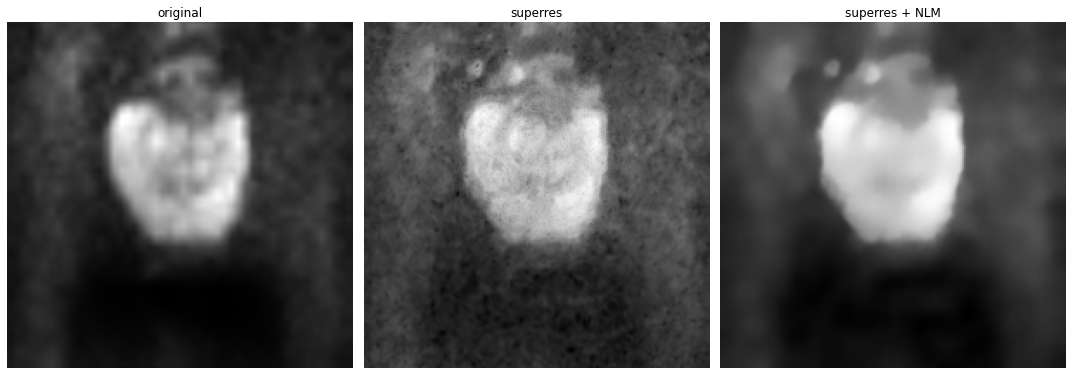

100%|██████████| 1000/1000 [00:41<00:00, 23.93it/s]


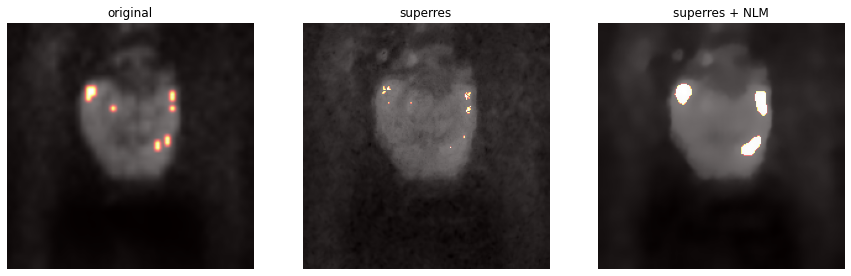

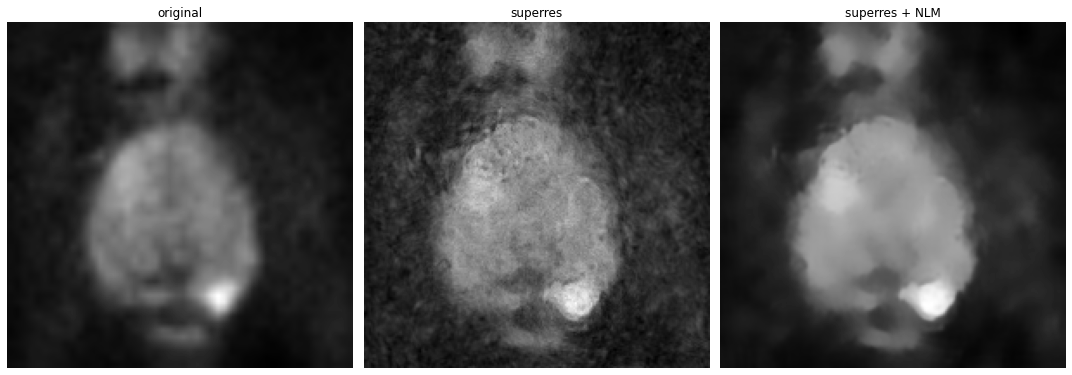

100%|██████████| 1000/1000 [00:43<00:00, 22.98it/s]


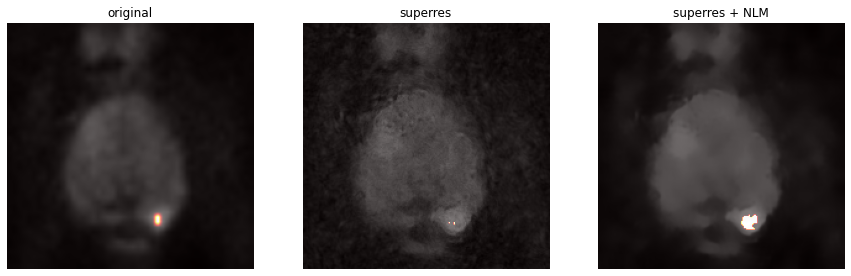

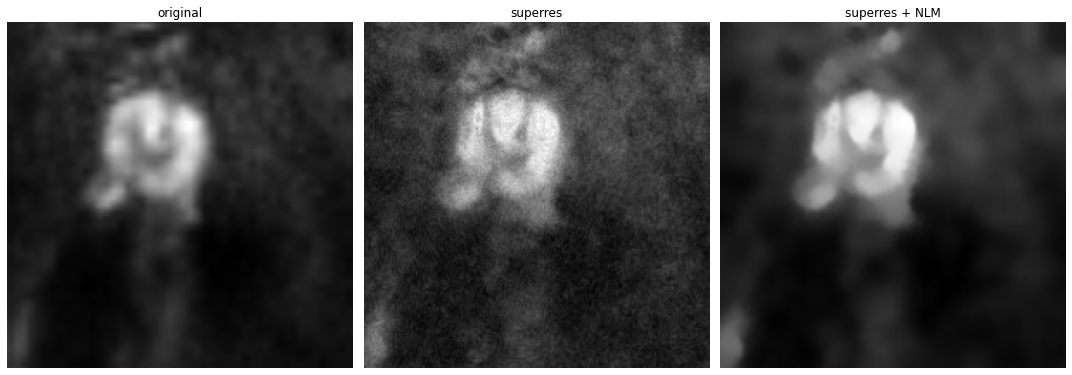

100%|██████████| 1000/1000 [00:21<00:00, 45.72it/s]


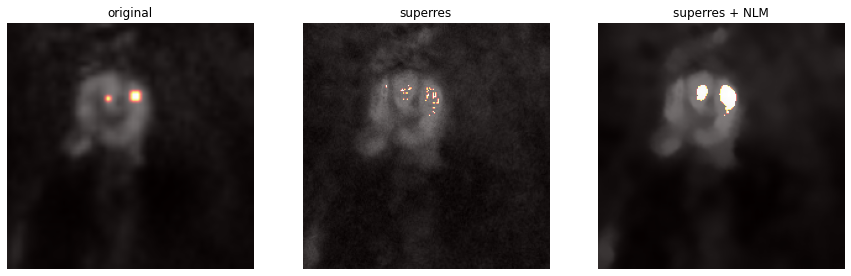

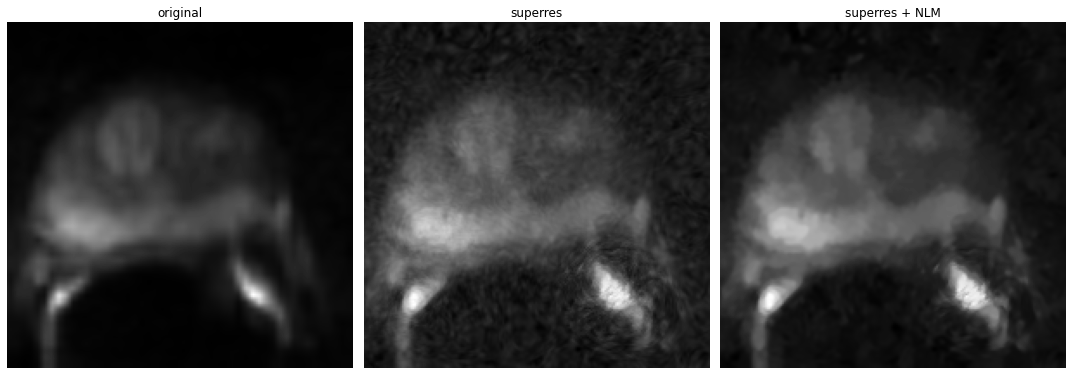

100%|██████████| 1000/1000 [00:43<00:00, 22.90it/s]


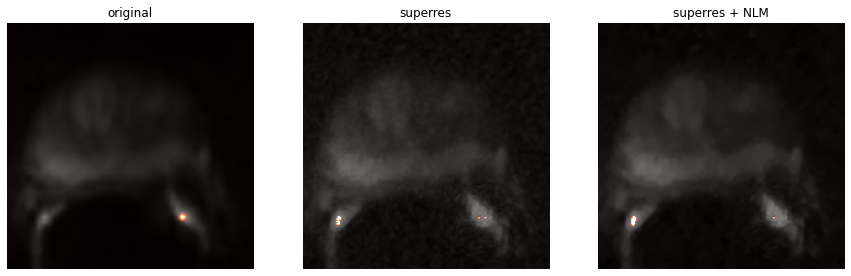

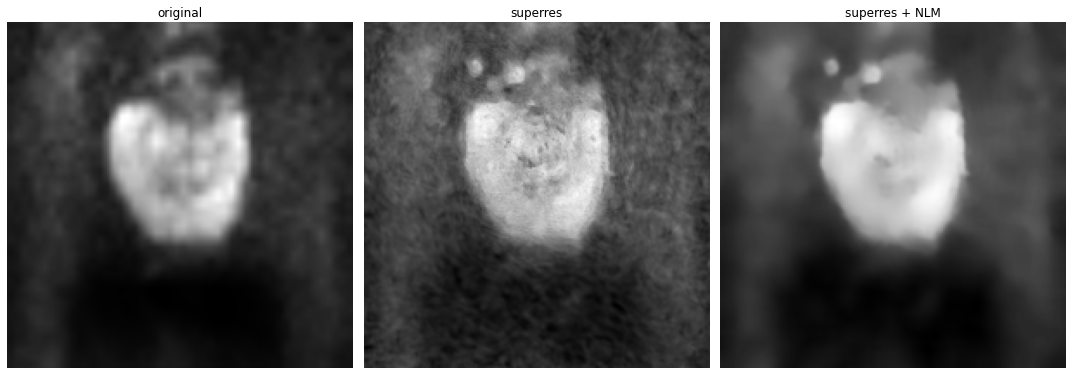

100%|██████████| 1000/1000 [00:41<00:00, 23.96it/s]


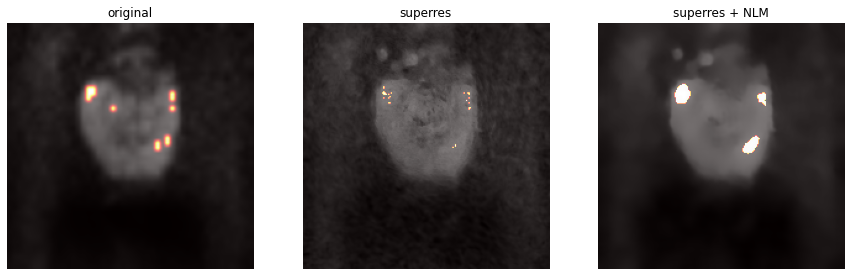

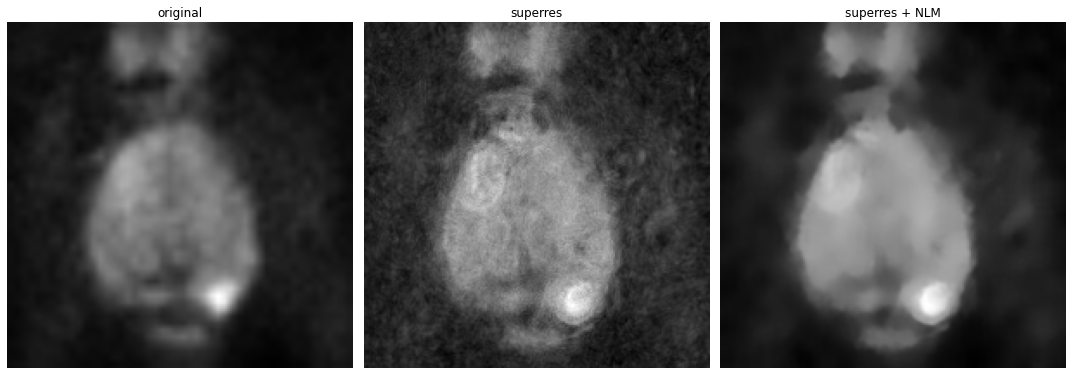

100%|██████████| 1000/1000 [00:43<00:00, 23.01it/s]


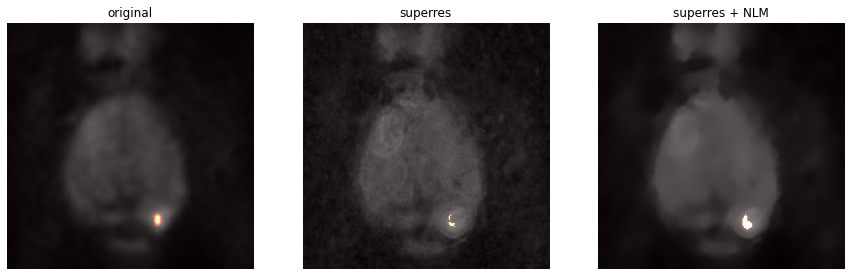

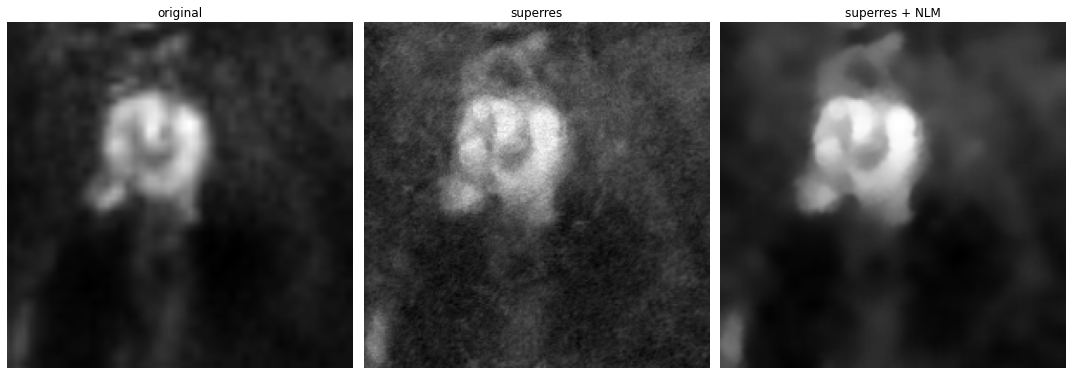

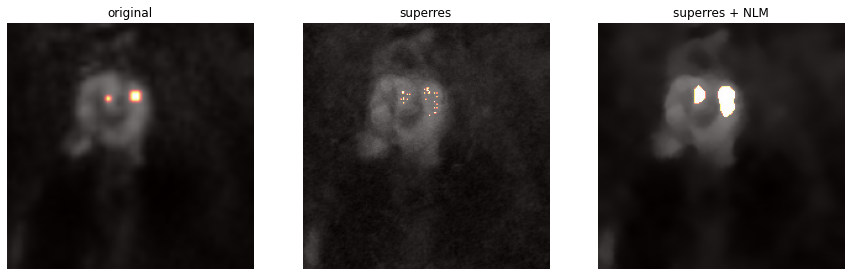

In [18]:
total_steps = 1000
orig_CC_ratio_list = []
SR_CC_ratio_list = []
NLM_CC_ratio_list = []
for seed in range(5):
    torch.manual_seed(seed)
    orig_CC_ratio = []
    SR_CC_ratio = []
    NLM_CC_ratio = []
    for case in cases:
        _slice = case.cancer_slice

        predicted_XYZ = []
        original_XYZ = []

        ends = sum(case.acquisitions)
        img_dataset = []
        for acq in range(ends):
            img_dataset.append(Image.fromarray(case.dwi[40:90, 40:90, _slice, acq]))

        dataset = ImageFitting_set(img_dataset)
        orig = dataset.mean
        original_XYZ.append(orig)
        dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
        img_siren = Siren(in_features=2, out_features=1, hidden_features=128, 
                     hidden_layers=2, outermost_linear=True)
        img_siren.cuda()
        torch.cuda.empty_cache()
        optim = torch.optim.Adam(lr=0.0003, params=img_siren.parameters())
        ctr = 0
        for step in tqdm(range(total_steps)): # make sure to change this
            size = dataset.shape
            for sample in range(len(dataset)):                    
                ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
                ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
                model_output, coords = img_siren(model_input)
                #weights = ground_truth/ground_truth.sum()
                #weights -= weights.min()
                #weights += 0.000001
                weights = 1
                loss = weights*(model_output - ground_truth)**2
                loss = loss.mean()
                optim.zero_grad()
                loss.backward()
                optim.step()
            if not step % steps_til_summary:
                coords2 = get_mgrid(size[0]*scale, 2).cuda()
                superres, _ = img_siren(coords2)
                if not ctr:
                    predicted = superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy()
                    out_img = predicted
                else:
                    predicted += superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy()
                    out_img = predicted/(ctr+1)
                ctr += 1

        predicted_XYZ.append(superres.cpu().view(scale*size[0], scale* size[1]).detach().numpy())

        predicted = sum(predicted_XYZ)/len(predicted_XYZ)
        orig = sum(original_XYZ)/len(original_XYZ)    

        noisy = predicted
        patch_kw = dict(patch_size=5,      # 5x5 patches
                        patch_distance=6)
        sigma_est = 5

        denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
                                   **patch_kw)


        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15),
                               sharex=True, sharey=True)


        ax[0].imshow(rescale(orig, scale, anti_aliasing=False), cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('original')

        ax[1].imshow(noisy, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('superres')


        ax[2].imshow(denoise, cmap='gray')
        ax[2].axis('off')
        ax[2].set_title('superres + NLM')

        fig.tight_layout()
        plt.show()
        a = rescale(orig, 1, anti_aliasing=True)
        denoise_fast = denoise_nl_means(a, h=0.8 * sigma_est, fast_mode=True,
                                        **patch_kw)
        (thresh, blackAndWhiteImage) = cv2.threshold(a, a.max()*0.95, 255, cv2.THRESH_BINARY)
        (thresh, blackAndWhiteImage2) = cv2.threshold(noisy, noisy.max()*0.95, 255, cv2.THRESH_BINARY)
        (thresh, blackAndWhiteImage3) = cv2.threshold(denoise, denoise.max()*0.95, 255, cv2.THRESH_BINARY)

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15),
                               sharex=True, sharey=True)


        ax[0].imshow(rescale(a, scale, anti_aliasing=False), cmap='gray')
        ax[0].imshow(rescale(blackAndWhiteImage, scale, anti_aliasing=True), 'hot',alpha=0.5)
        ax[0].axis('off')
        ax[0].axis('off')
        ax[0].set_title('original')

        ax[1].imshow(noisy, cmap='gray')
        ax[1].imshow(blackAndWhiteImage2,'hot', alpha=0.5)
        ax[1].axis('off')
        ax[1].axis('off')
        ax[1].set_title('superres')


        ax[2].imshow( denoise, cmap='gray')
        ax[2].imshow(blackAndWhiteImage3, 'hot', alpha=0.5)
        ax[2].axis('off')
        ax[2].set_title('superres + NLM')

        orig_CC_ratio.append((orig[tuple(i -40 for i in case.cancer_loc)]-orig[tuple(i -40 for i in case.collateral_loc)])/orig[tuple(i -40 for i in case.cancer_loc)])
        SR_CC_ratio.append((noisy[tuple((i -40) * scale for i in case.cancer_loc)]-noisy[tuple((i -40) * scale for i in case.collateral_loc)])/noisy[tuple((i -40) * scale for i in case.cancer_loc)]) 
        NLM_CC_ratio.append((denoise[tuple((i -40) * scale for i in case.cancer_loc)]-denoise[tuple((i-40) * scale for i in case.collateral_loc)])/denoise[tuple((i -40) * scale for i in case.cancer_loc)])

    orig_CC_ratio_list.append(orig_CC_ratio)
    SR_CC_ratio_list.append(SR_CC_ratio)
    NLM_CC_ratio_list.append(NLM_CC_ratio)
    
import csv

with open('w_orig.csv', 'w') as f:
    write = csv.writer(f)    
    write.writerows(orig_CC_ratio_list)
    
with open('w_sr.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(SR_CC_ratio_list)
    
with open('w_nlm.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(NLM_CC_ratio_list)

In [77]:
calculate_contrast(case, orig2, gland_start)[0]

-1.6929585379432917